In [1]:
#Installing VGG16 convolutional base
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [2]:
#Extracting features using pretrained conv base

import os
import numpy as np
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

base_dir = '/home/joel/DL_Python/Dogs_vs_Cats_Dataset_small/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size,
                                           class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch #replacing the i * batch_size to (i+1) *
                                                                         #batch_size (4,4,512)-zero arrays 
                                                                         #with the predictions
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch     #same for labels
        i += 1
        if i * batch_size >= sample_count:
            break #break the indefinitely loop after every image has seen once
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [9]:
#Define densely connected classifier with dropout and train it

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30,batch_size=20,
                    validation_data=(validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.5534 - acc: 0.7170 - val_loss: 0.4134 - val_acc: 0.8410
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.4066 - acc: 0.8170 - val_loss: 0.3434 - val_acc: 0.8760
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.3396 - acc: 0.8545 - val_loss: 0.3104 - val_acc: 0.8840
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.2952 - acc: 0.8845 - val_loss: 0.2887 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.2793 - acc: 0.8910 - val_loss: 0.2724 - val_acc: 0.8970
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.2590 - acc: 0.8980 - val_loss: 0.2629 - val_acc: 0.9020
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.2398 - acc: 0.9115 - val_loss: 0.2560 - val_acc: 0.9030


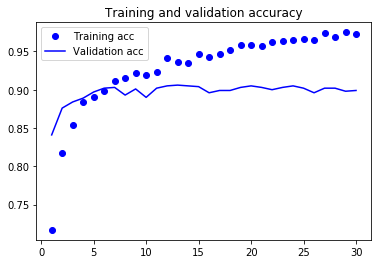

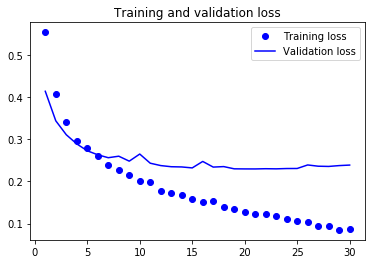

In [11]:
#Plotting test and validation accuracy and loss

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()